In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.utils import resample

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from bnlp.corpus.util import remove_stopwords


c:\Users\farha\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
rstate=10

In [3]:
df = pd.read_csv("Bengali hate speech.csv")

In [4]:
df.dropna(inplace=True)

In [5]:
train2, test2 = train_test_split(df, test_size=0.3,random_state=10, shuffle=True)

train2 = train2[['hate','sentence']]
test2 = test2[['sentence']]

print("Training Set 2 :"% train2.columns, train2.shape)
print("Test Set 2 :"% test2.columns, test2.shape)
print('Train Set 2 -----')
print(train2.isnull().sum())
print('Test Set 2 -----')
print(test2.isnull().sum())
train2.head()

Training Set 2 : (21000, 2)
Test Set 2 : (9000, 1)
Train Set 2 -----
hate        0
sentence    0
dtype: int64
Test Set 2 -----
sentence    0
dtype: int64


,hate,sentence
19147,0,উনি আমাদের যুবকদের মাথার মুকুট উনি বাংলাদেশের ...
5380,1,দেযাওয়ান বাগি একটা পুটকা মাছ
15486,0,ভালোই হলো। ওর পরিবারে আর দুধের সংকট থাকবে না।
19794,0,ভাই সব ভালো লাগলো কিন্ত হাফিজুর রহমান সিদ্দিকি...
11102,0,পাপনকে পদত্যাগ করা উচিত না হলে সাকিব ইন্ল্ড হয়...


In [6]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [7]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda x: str(x))  
    return df
test_clean = clean_text(test2, "sentence")
train_clean = clean_text(train2, "sentence")

train_majority = train_clean[train_clean.hate==0]
train_minority = train_clean[train_clean.hate==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['hate'].value_counts()

1    13997
0    13997
Name: hate, dtype: int64

In [8]:
train_upsampled

,hate,sentence
8712,1,তুর তুই মাগি পাও
2697,1,ছেলে দুটাই মাদারচুদ। যেই খানকির পোলায় কইছিলো এ...
9931,1,তোর কুলাঙ্গারকে আমার সামনে পড়লে জুতা পেটা করত...
5926,1,কত্তার বাচ্ছারা ভন্ডদের মারে চুদি
3545,1,সালার পাগল সহবাস না ইটাকে জিনা বলা লাগে সহবাস ...
...,...,...
10201,0,হাহাহা
28017,0,রানুদি জে হাতটা জোড় কোরে আছে ভালো কোরে সবাই দে...
17728,0,আমি প্রশাসনকে দৃষ্টি আকর্ষণ করে বলছি মুন্নিকে ...
29199,0,রানু মণ্ডল কে আবার রানাঘাট নাম্বার প্লাটফর্ম এ...


In [9]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

import matplotlib.pyplot as plt
from matplotlib import font_manager

# Function for generating word clouds
def generate_wordcloud(data,title):
  data = [tuple(x) for x in data.values]
  wc = WordCloud(font_path="Siyamrupali.ttf",width=1080, height=720, max_words=150,colormap="Dark2").generate_from_frequencies(dict(data))
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  if(title==1):
    title="Hate Comments"
  else:
    title="Non Hate Comments"
  plt.title('\n'.join(wrap("Word Cloud of "+title,60)),fontsize=13)
  plt.show()

,hate,sentence
8712,1,তুর তুই মাগি পাও
2697,1,ছেলে দুটাই মাদারচুদ। যেই খানকির পোলায় কইছিলো এ...
9931,1,তোর কুলাঙ্গারকে আমার সামনে পড়লে জুতা পেটা করত...
5926,1,কত্তার বাচ্ছারা ভন্ডদের মারে চুদি
3545,1,সালার পাগল সহবাস না ইটাকে জিনা বলা লাগে সহবাস ...
...,...,...
2371,1,পতিতা আর মাগির দালাল দের বিচারক কে বানাইছে
8629,1,লোক টাকে হারামি হারামি লাগে৷
6441,1,তুই তো শালা কুত্তার বাচ্
9512,1,তোর গূদ মারতে গেলে বিএসএফ ভারতের সেনা


C:\Users\farha\AppData\Local\Temp\ipykernel_21876\1890777781.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['temp_list'] = temp['sentence'].apply(lambda x:str(x).split())


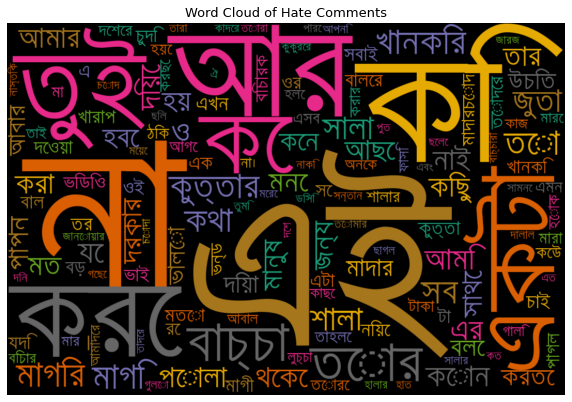

,hate,sentence
19147,0,উনি আমাদের যুবকদের মাথার মুকুট উনি বাংলাদেশের ...
15486,0,ভালোই হলো। ওর পরিবারে আর দুধের সংকট থাকবে না।
19794,0,ভাই সব ভালো লাগলো কিন্ত হাফিজুর রহমান সিদ্দিকি...
11102,0,পাপনকে পদত্যাগ করা উচিত না হলে সাকিব ইন্ল্ড হয়...
22055,0,মামা তোমার দাঁড়ি মুছ ঠিক কর আগে
...,...,...
10201,0,হাহাহা
28017,0,রানুদি জে হাতটা জোড় কোরে আছে ভালো কোরে সবাই দে...
17728,0,আমি প্রশাসনকে দৃষ্টি আকর্ষণ করে বলছি মুন্নিকে ...
29199,0,রানু মণ্ডল কে আবার রানাঘাট নাম্বার প্লাটফর্ম এ...


C:\Users\farha\AppData\Local\Temp\ipykernel_21876\1890777781.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['temp_list'] = temp['sentence'].apply(lambda x:str(x).split())


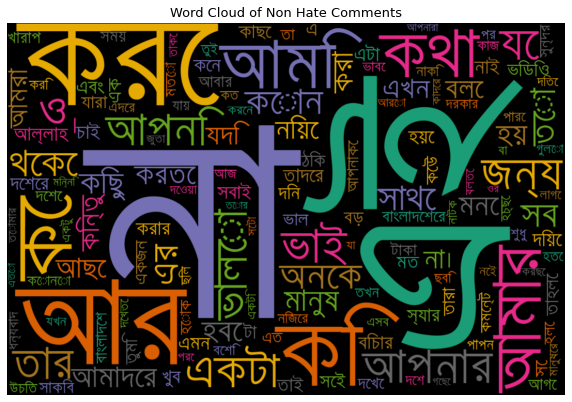

In [10]:
from collections import Counter 
hateList=[1,0]
for i in hateList:
    temp=train_upsampled.loc[train_upsampled['hate'] == i]
    display(temp)
    temp['temp_list'] = temp['sentence'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(500000))
    temp.columns = ['Common_words','count']
    generate_wordcloud(temp,i)

In [11]:
import string 
def remove_punctuation_from_sentence(sentence):
    sentence_without_punctuation="".join([c for c in sentence if c not in string.punctuation])
    return sentence_without_punctuation

df['sentence without punctuation'] = df['sentence'].apply(lambda x:remove_punctuation_from_sentence(x))
df.head()

,sentence,hate,category,sentence without punctuation
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব


In [12]:
df['Removed Stopped word'] = df['sentence without punctuation'].apply(lambda x: remove_stopwords(x,stopwords))
df.head()

,sentence,hate,category,sentence without punctuation,Removed Stopped word
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]"
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, দরকার]"
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,..."
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, পাঠার, মত, যায়]"
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,"[তুই, শালা, গাজা, খাইছচ, ।, তুর, মার, হেডায়, খ..."


In [13]:
df['hate_speech']=df['Removed Stopped word']
display(df['hate_speech'])


0                           [যত্তসব, পাপন, শালার, ফাজলামী]
1                        [পাপন, শালা, রে, রিমান্ডে, দরকার]
2        [জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,...
3                           [শালা, লুচ্চা, পাঠার, মত, যায়]
4        [তুই, শালা, গাজা, খাইছচ, ।, তুর, মার, হেডায়, খ...
                               ...                        
29995                                         [মেনে, নেয়া]
29996                         [ধন্যবাদ, জানাই, আইনপসাসনকে]
29997      [কাসমির, কাসমিরই, নিজশ্যই, সাদিন, হওয়ার, দরকার]
29998                 [কলমি, পিলিজ, আপু, মনি, কিওট, লাগছে]
29999                              [পাকিস্তান, সাথে, জড়িত]
Name: hate_speech, Length: 30000, dtype: object

In [14]:
y=df['hate']

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['hate_speech'])
sequences = tokenizer.texts_to_sequences(df['hate_speech'])
x= pad_sequences(sequences, maxlen=100)
print(x)

[[    0     0     0 ...    24   157 12561]
 [    0     0     0 ...    69   694    17]
 [    0     0     0 ...  1645     4     1]
 ...
 [    0     0     0 ...  7858   424    17]
 [    0     0     0 ...  4980 52404   264]
 [    0     0     0 ...   541     6   438]]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=rstate)

In [17]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=100))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [19]:
model.fit(X_train, y_train, batch_size=32, epochs=11 ,validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy*100.0)

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Test F1 Score:", f1)



Epoch 1/11
657/657 [==============================] - 70s 104ms/step - loss: 0.3961 - accuracy: 0.8272 - val_loss: 0.3175 - val_accuracy: 0.8759
Epoch 2/11
657/657 [==============================] - 66s 101ms/step - loss: 0.1892 - accuracy: 0.9290 - val_loss: 0.3434 - val_accuracy: 0.8652
Epoch 3/11
657/657 [==============================] - 67s 102ms/step - loss: 0.1024 - accuracy: 0.9644 - val_loss: 0.4550 - val_accuracy: 0.8494
Epoch 4/11
657/657 [==============================] - 67s 101ms/step - loss: 0.0646 - accuracy: 0.9781 - val_loss: 0.4917 - val_accuracy: 0.8483
Epoch 5/11
657/657 [==============================] - 67s 102ms/step - loss: 0.0467 - accuracy: 0.9839 - val_loss: 0.5443 - val_accuracy: 0.8397
Epoch 6/11
657/657 [==============================] - 66s 101ms/step - loss: 0.0371 - accuracy: 0.9877 - val_loss: 0.5788 - val_accuracy: 0.8328
Epoch 7/11
657/657 [==============================] - 66s 100ms/step - loss: 0.0284 - accuracy: 0.9900 - val_loss: 0.7425 - val_ac

In [20]:
#Saving the model
model_json=model.to_json()
with open("bangla-sequential-model.json","w")as json_file:
    json_file.write(model_json)
model.save_weights("bangla-sequential-model_wieghts.h5")

In [21]:
model.save("bangla_sequential_model.h5")

In [22]:
from tensorflow.keras.models import load_model

loaded_model = load_model(r"bangla_sequential_model.h5")

In [23]:
text="খানকি মাগি জারজ"
text=remove_punctuation_from_sentence(text)
text=remove_stopwords(text=text,stopwords=stopwords)
print(text)

['খানকি', 'মাগি', 'জারজ']


In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
sequences = tokenizer.texts_to_sequences([text])
pdsequences= pad_sequences(sequences, maxlen=100)
prediction = loaded_model.predict(pdsequences)[0][0]
predicted_class = (prediction < 0.5).astype(int)
print(predicted_class)

1/1 [==============================] - 0s 178ms/step
1
